# Chest X-Ray Pneumonia Detection with a CNN (PyTorch)

This notebook trains a **convolutional neural network (CNN)** to classify chest X-ray images as **Normal** vs **Pneumonia**.
It covers a complete mini-pipeline:
- dataset loading with `torchvision.datasets.ImageFolder`
- resizing + grayscale + normalization
- training with `CrossEntropyLoss` and `Adam`
- evaluation with accuracy and a classification report


In [1]:
import os

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import userdata

import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

import torchvision
from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [3]:
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [4]:
!kaggle datasets download paultimothymooney/chest-xray-pneumonia

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
other
chest-xray-pneumonia
 96% 2.21G/2.29G [00:16<00:02, 38.7MB/s]
100% 2.29G/2.29G [00:16<00:00, 152MB/s] 


In [5]:
!unzip -q chest-xray-pneumonia.zip

In [31]:
path = 'chest_xray'
train_path = os.path.join(path, 'train')
test_path = os.path.join(path, 'test')

## Notes on the data pipeline

We use:

1. `torchvision.datasets.ImageFolder(...)` to load the dataset from a folder-per-class structure.
2. `torch.utils.data.DataLoader(...)` to create mini-batches for training and testing.

The `transform = transforms.Compose([...])` block is where preprocessing happens at load time.
In this notebook we apply:

- **Resize** to 224×224 (a common input size for CNN backbones)
- **Grayscale** (1 channel) since X-rays do not require RGB channels
- **Tensor conversion** (`ToTensor()`)
- **Normalization** to stabilize training


In [36]:
def load_dataset(train_path, test_path, batch_size=64):

    transform = transforms.Compose([

        transforms.Resize((224, 224)),  # Resize images to 224x224
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(0.49, 0.248),
    ])

    train_dataset = datasets.ImageFolder(root=train_path, transform=transform)
    test_dataset = datasets.ImageFolder(root=test_path, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, transform

In [37]:
train_loader, test_loader, transform = load_dataset(train_path, test_path, batch_size=128)

In [38]:
train_loader.dataset.classes

['NORMAL', 'PNEUMONIA']

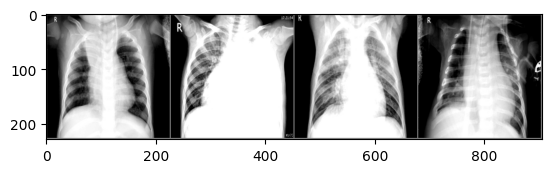

Labels: ['PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA', 'PNEUMONIA']


In [39]:
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:4]))

# Print labels (as returned by ImageFolder)
print('Labels:', [train_loader.dataset.classes[label] for label in labels[:4]])

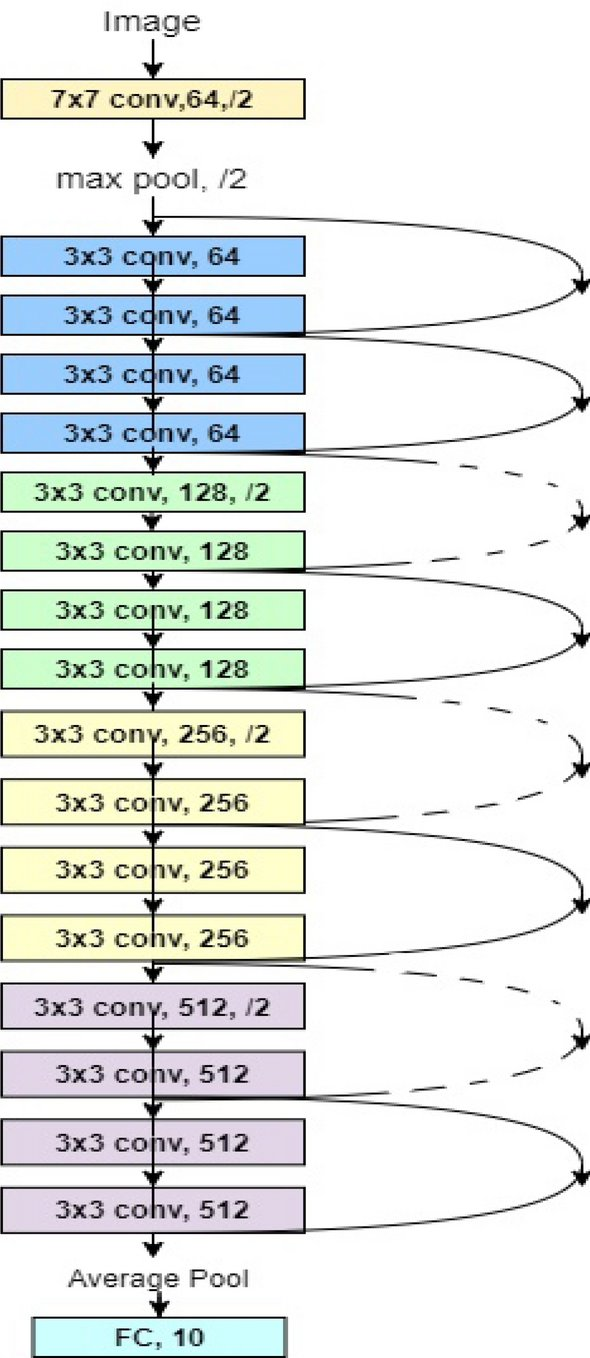

In [21]:
# ---------------------------- 1. Residual block -----------------------------
class BasicBlock(nn.Module):
    """A 2-layer residual block (conv3x3 → BN → ReLU) ×2 + skip connection."""
    def __init__(self, in_ch, out_ch, stride=1):
        super().__init__()

        # First conv changes spatial size if stride = 2
        self.conv1 = nn.Conv2d(in_ch, out_ch, 3, stride, 1, bias=False)
        self.bn1   = nn.BatchNorm2d(out_ch)

        # Second conv keeps size
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, 1, 1, bias=False)
        self.bn2   = nn.BatchNorm2d(out_ch)

        # If channels or stride change, adjust the “identity” path
        self.skip = (
            nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, stride, bias=False),
                nn.BatchNorm2d(out_ch)
            )
            if stride != 1 or in_ch != out_ch else nn.Identity()
        )

    def forward(self, x):
        identity = self.skip(x)

        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        out += identity          # residual add
        return F.relu(out)

# ---------------------------- 2. ResNet-18 -----------------------------------
class ResNet18(nn.Module):
    def __init__(self, in_channels, num_classes=10):
        super().__init__()
        # Initial “stem”
        self.stem = nn.Sequential(
            nn.Conv2d(in_channels, 64, 7, 2, 3, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, 2, 1),
        )

        # Residual layers: (channels, blocks, stride_of_first_block)
        self.layer1 = self._make_layer(64,  64, 2, 1)  # 2 blocks
        self.layer2 = self._make_layer(64, 128, 2, 2)
        self.layer3 = self._make_layer(128, 256, 2, 2)
        self.layer4 = self._make_layer(256, 512, 2, 2)

        # Classification head
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc      = nn.Linear(512, num_classes)

        # He (Kaiming) init for conv layers
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")

    # -------------------------------------------------------------------------
    def _make_layer(self, in_ch, out_ch, blocks, stride):
        layers = [BasicBlock(in_ch, out_ch, stride)]
        for _ in range(1, blocks):
            layers.append(BasicBlock(out_ch, out_ch))
        return nn.Sequential(*layers)

    # -------------------------------------------------------------------------
    def forward(self, x):
        x = self.stem(x)           # 224→56
        x = self.layer1(x)         # 56→56
        x = self.layer2(x)         # 56→28
        x = self.layer3(x)         # 28→14
        x = self.layer4(x)         # 14→7
        x = self.avgpool(x)        # 7→1
        x = torch.flatten(x, 1)    # (B, 512)
        return self.fc(x)

In [22]:
def train_model(model, train_loader, valid_loader, criterion, optimizer, device, num_epochs=5):
    model.to(device)

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_train_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
        avg_train_loss = total_train_loss / len(train_loader)

        # Validation Phase
        model.eval()
        total_valid_loss = 0
        with torch.no_grad():
            for inputs, labels in valid_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                total_valid_loss += loss.item()

        avg_valid_loss = total_valid_loss / len(valid_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_valid_loss:.4f}')

    return model

In [23]:
print(len(train_loader), len(test_loader))

41 5


In [24]:
def predict_and_evaluate(model, data_loader, device):
    model.eval()
    predictions, labels = [], []

    with torch.no_grad():
        for inputs, true_labels in data_loader:
            inputs = inputs.to(device)
            true_labels = true_labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predictions.extend(predicted.view(-1).cpu().numpy())
            labels.extend(true_labels.view(-1).cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')

    return predictions, labels, accuracy, precision, recall, f1

def show_predictions(data_loader, predictions, labels, class_names, num_images=10):
    plt.figure(figsize=(12, 8))

    for i in range(num_images):
        inputs, _ = next(iter(data_loader))
        plt.subplot(1, num_images, i + 1)
        plt.imshow(inputs[i][0], cmap='gray')  # assuming grayscale images
        plt.title(f'Pred: {class_names[predictions[i]]}\nTrue: {class_names[labels[i]]}')
        plt.axis('off')

    plt.show()

In [40]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet18(1, num_classes=2)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

trained_model = train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=5)

Epoch 1/5, Train Loss: 0.2990, Validation Loss: 2.4417
Epoch 2/5, Train Loss: 0.1028, Validation Loss: 0.6991
Epoch 3/5, Train Loss: 0.0712, Validation Loss: 0.7959
Epoch 4/5, Train Loss: 0.0656, Validation Loss: 0.8375
Epoch 5/5, Train Loss: 0.0557, Validation Loss: 1.5685


In [41]:
model = trained_model.to(device)  # Your trained model

# Get predictions and metrics
predictions, labels, accuracy, precision, recall, f1 = predict_and_evaluate(model, test_loader, device)
# Print metrics
print(f'Accuracy for real model: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}')

Accuracy for real model: 0.6859, Precision: 0.7910, Recall: 0.6859, F1-Score: 0.6043


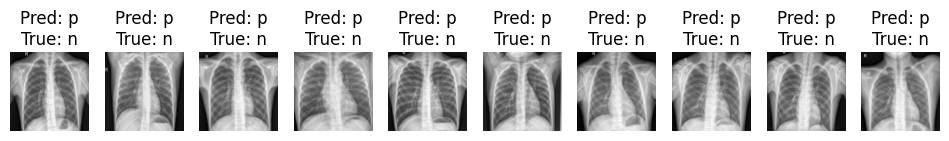

In [42]:
# Assuming you have a list of class names
class_names = ['NORMAL', 'PNEUMONIA'] # normal, pneumonia
c_n = ['n', 'p']

# Display some predictions
show_predictions(test_loader, predictions, labels, c_n)

In [43]:
# prompt: get the number of parameters of the model

num_params = sum(p.numel() for p in model.parameters())
print(f'The model has {num_params} parameters.')

The model has 11171266 parameters.


In [44]:
# prompt: get architecture info of the model

model

ResNet18(
  (stem): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip): Identity()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(